In [1]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import itertools
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive/


In [ ]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = '/content/drive/MyDrive/root_patches/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [ ]:
df_unlab = pd.read_csv('unlabeled.csv')
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
validation_set = pd.read_csv('validation_set.csv')

training_data, training_labels, _ = prepareDataNN(training_set)
validation_data, validation_labels, _ = prepareDataNN(validation_set)
test_data, test_labels, _ = prepareDataNN(test_set)
print(len(training_labels) + len(validation_labels), len(test_labels))

KeyboardInterrupt: ignored

In [ ]:
def get_preditictions(model, test_data):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    #print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

In [ ]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomTranslation(0.8, 0.5),
      layers.RandomFlip("vertical"),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.3),
    ]
)

In [ ]:
def make_model(input_shape):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)###
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.50)(x) # increased from .25

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3) 
model = make_model(input_shape=image_size)
keras.utils.plot_model(model, to_file='code/figures/CNN_new2.png', show_shapes=True)

In [ ]:
X, Y = np.array(training_data + validation_data), np.array(training_labels + validation_labels)
X.shape, Y.shape 

((1915, 256, 256, 3), (1915,))

In [ ]:
#train with kfold

from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
k = 1
epochs = 300

for train_ind, val_ind in kf.split(X):
  x_train,y_train = X[train_ind,:,:,:], Y[train_ind]
  x_val,y_val = X[val_ind,:,:,:], Y[val_ind]

  callbacks = [
      keras.callbacks.ModelCheckpoint("code/ckpts/cnn2_kf{}.h5".format(k), save_best_only=True, mode='min'),
      keras.callbacks.ReduceLROnPlateau(),
  ]
  tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                  histogram_freq=1, 
                  write_graph=True, 
                  write_images=False)
  
  model = make_model(input_shape=image_size)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  hist_cnn = model.fit(
      x=x_train, y=y_train , epochs=epochs, callbacks=[callbacks, tensorboard], batch_size=32, validation_data=(x_val, y_val))

  # save history 
  with open('code/ckpts/trainHistoryCNN2_kf{}'.format(k), 'wb') as file_pi:
      pickle.dump(hist_cnn.history, file_pi)
  k += 1

Epoch 1/300
40/40 [==============================] - 17s 67ms/step - loss: 0.7769 - accuracy: 0.6646 - val_loss: 0.7226 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 2/300
40/40 [==============================] - 1s 26ms/step - loss: 0.5337 - accuracy: 0.7155 - val_loss: 1.0018 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 3/300
40/40 [==============================] - 1s 26ms/step - loss: 0.5578 - accuracy: 0.7202 - val_loss: 1.1468 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 4/300
40/40 [==============================] - 1s 26ms/step - loss: 0.5387 - accuracy: 0.7194 - val_loss: 1.1696 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 5/300
40/40 [==============================] - 1s 27ms/step - loss: 0.5394 - accuracy: 0.7492 - val_loss: 0.9532 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 6/300
40/40 [==============================] - 1s 27ms/step - loss: 0.5103 - accuracy: 0.7508 - val_loss: 1.1511 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 7/300
40/40 [==============================] - 1s 26ms/step - l

In [ ]:
df_unlab = pd.read_csv('unlabeled.csv')
# unlabeled
X, Y, _ = prepareDataNN(df_unlab)

In [ ]:
# assess performance on test 
# load kfold models
model1 = make_model(input_shape=image_size)
model1.load_weights("code/ckpts/cnn2_kf1.h5")

model2 = make_model(input_shape=image_size)
model2.load_weights("code/ckpts/cnn2_kf2.h5")

model3 = make_model(input_shape=image_size)
model3.load_weights("code/ckpts/cnn2_kf3.h5")

models = [model1, model2, model3]
merged_preds = np.zeros([len(test_labels),])
# majority voting 
for m in models:
  pred_probs_cnn, pred_class_cnn = get_preditictions(m, test_data)
  merged_preds += np.array(pred_class_cnn)

merged_preds = merged_preds // 2 # convert to classes

print(classification_report(test_labels,  merged_preds))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90        99
         1.0       0.83      0.79      0.81        56

    accuracy                           0.86       155
   macro avg       0.86      0.85      0.85       155
weighted avg       0.86      0.86      0.86       155



In [ ]:
model.load_weights("code/ckpts/new_cnn_51.h5")
pred_probs_cnn, pred_class_cnn = get_preditictions(model, test_data)
print(classification_report(test_labels,  pred_class_cnn))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90        71
         1.0       0.94      0.81      0.87        62

    accuracy                           0.89       133
   macro avg       0.90      0.88      0.89       133
weighted avg       0.89      0.89      0.89       133



In [ ]:
# predict on unlabeled data
merged_preds = np.zeros([len(X),])
# majority voting 
for m in models:
  pred_probs_cnn, pred_class_cnn = get_preditictions(m, X)
  merged_preds += np.array(pred_class_cnn)

df_unlab['plastic'] = merged_preds // 2 # convert to classes

In [ ]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
validation_set = pd.read_csv('validation_set.csv')

In [ ]:
all_labeled = pd.concat([training_set, validation_set, df_unlab], ignore_index=True)
all_labeled.to_csv('/content/drive/MyDrive/all_labeled_notest.csv')

In [ ]:
if not os.path.exists('/content/drive/MyDrive/predicted_patches/'):
  os.makedirs('/content/drive/MyDrive/predicted_patches/litter/')
  os.makedirs('/content/drive/MyDrive/predicted_patches/no_litter/')

In [ ]:
import shutil
import pandas as pd

patches_rootdir='/content/drive/MyDrive/root_patches/patches/'
all_labeled=pd.read_csv('/content/drive/MyDrive/all_labeled_notest.csv')
for i in range(len(all_labeled)):
  row = all_labeled.loc[i, :]
  patch_filename = os.path.join(patches_rootdir, os.path.basename(row['patch_filename']))
  if row['plastic'] == 1:
    patch_dest = os.path.join('/content/drive/MyDrive/predicted_patches/training_and_unlabeled/litter/', os.path.basename(row['patch_filename']))
    shutil.copy(patch_filename, patch_dest)
  elif row['plastic'] == 0:
    patch_dest = os.path.join('/content/drive/MyDrive/predicted_patches/training_and_unlabeled/no_litter/', os.path.basename(row['patch_filename']))
    shutil.copy(patch_filename, patch_dest)
  else:
    print("patch unlabeled: {}, {}".format(os.path.basename(row['patch_filename']), row['plastic']))

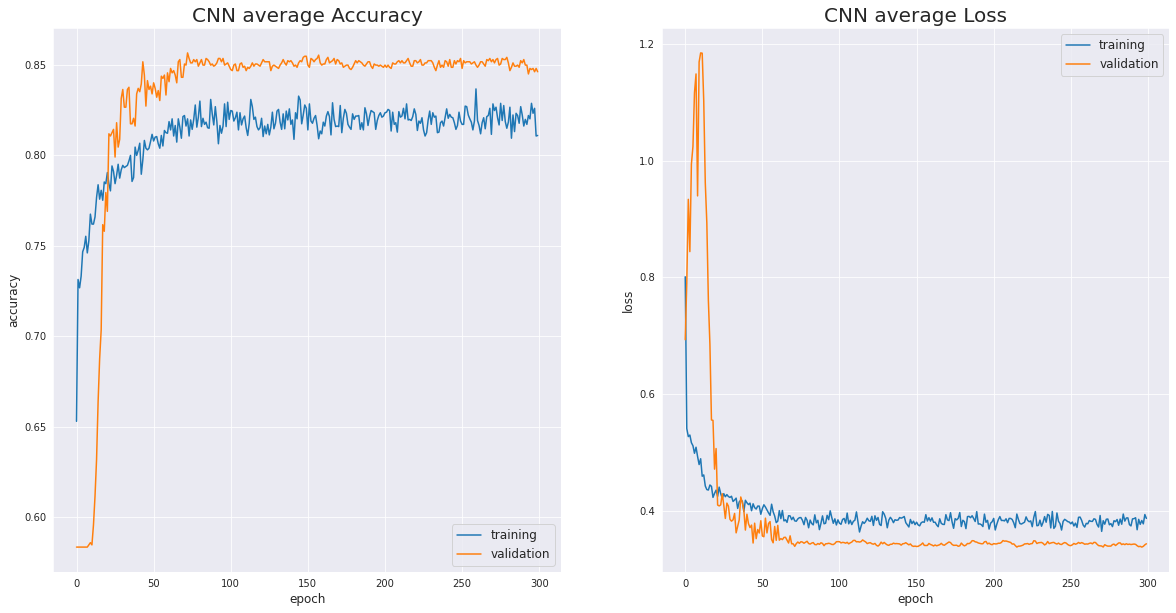

In [4]:
hist_cnn1 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf1')
hist_cnn2 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf2')
hist_cnn3 = pd.read_pickle('code/ckpts/trainHistoryCNN_kf3')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(np.mean([hist_cnn1['accuracy'], hist_cnn2['accuracy'], hist_cnn3['accuracy']], axis=0))
plt.plot(np.mean([hist_cnn1['val_accuracy'], hist_cnn2['val_accuracy'], hist_cnn3['val_accuracy']], axis=0))
plt.title('CNN average Accuracy', fontsize=20)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='lower right', fontsize='large')
plt.subplot(122)
plt.plot(np.mean([hist_cnn1['loss'], hist_cnn2['loss'], hist_cnn3['loss']], axis=0))
plt.plot(np.mean([hist_cnn1['val_loss'], hist_cnn2['val_loss'], hist_cnn3['val_loss']], axis=0))
plt.title('CNN average Loss', fontsize=20)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right',  fontsize='large')
plt.savefig("code/figures/CNN_training_kf.png")

In [ ]:
len(np.mean([hist_cnn1['accuracy'], hist_cnn2['accuracy'], hist_cnn3['accuracy']], axis=0)) == len(hist_cnn3['accuracy'])

True